In [12]:
# load the estimates
include("../src/model/model.jl")
include("../src/estimation/estimation.jl")
using DelimitedFiles

M = CSV.read("../data/MarriageFile.csv",DataFrame,missingstring="NA")
P = CSV.read("../data/MarriagePanel.csv",DataFrame,missingstring="NA")
K = CSV.read("../data/KidPanel.csv",DataFrame,missingstring="NA")
cprobs = CSV.read("../data/CustodyMomentsSimple.csv",DataFrame).p[:]

F = FixedParams()
θ = Params(F)
V = values(F);
θ = (;θ...,cprobs)
θk = prod_pars()

x1 = readdlm("../output/est_stage1")[:]
x2 = readdlm("../output/est_stage2")[:]
x3 = readdlm("../output/est_stage3")[:]
x4 = readdlm("../output/est_stage4")[:]
x5 = readdlm("../output/est_stage5")[:]

θ,θk = update_all((x1,x2,x3,x4,x5),θ,θk,F);

# Checking Output from Model Estimates

## Model Fit

First, let's look at the model's fit in stage 4.

In [13]:
dat = prep_sim_data(M,P;R = 10)
moms0 = data_moms(M,P)
moms1 = get_moments(θ,V,F,dat)
mstring = ["FT - married","PT - married","FT - divorced","PT - divorced"]
mstring = [mstring;["divorce < $x years" for x in (5,10,15)]]
mstring = [mstring;["birth < $x years" for x in (2,4,6)]]
mstring = [mstring;["time to divorce - time to birth < $x years" for x in (0,5,10,15)]]

d = DataFrame(name = mstring,data = moms0, model = moms1)
d

Row,name,data,model
,String,Float64,Float64
1,FT - married,0.495037,0.4855
2,PT - married,0.289995,0.306975
3,FT - divorced,0.657015,0.680226
4,PT - divorced,0.192676,0.259777
5,divorce < 5 years,0.0308911,0.0236436
6,divorce < 10 years,0.0942574,0.0829703
7,divorce < 15 years,0.143762,0.162297
8,birth < 2 years,0.384554,0.440911
9,birth < 4 years,0.654257,0.631089


Now let's compare the increase in labor supply prior to divorce in the data to the model (not targeted).

In [14]:
mod = (;θ,values=V,F)
solve_all!(mod)
TD,TF,L_sim, Ω_sim, D = data_gen(mod,dat)
tsd = get_tsd(TD,dat);


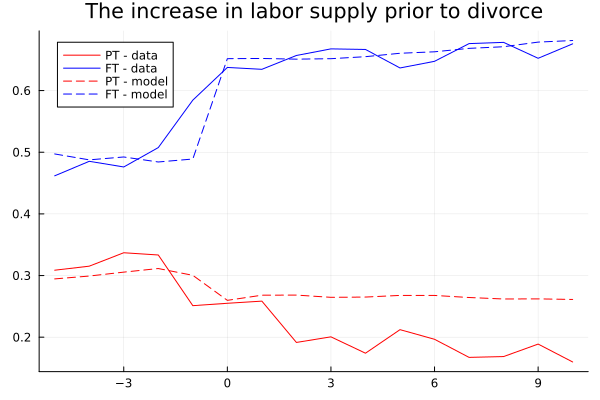

In [15]:
using Plots
L1 = [mean(L_sim[tsd.==x].==g) for x in -5:10, g in 1:2]
L0 = @chain P begin
    @subset :TSD.>=-5 :TSD.<=10
    @select :TSD :M_hrs
    dropmissing()
    groupby(:TSD)
    @combine :PT = mean(:M_hrs.>0 .&& :M_hrs.<=1500) :FT = mean(:M_hrs.>1500)
end
p = plot()
plot!(p,-5:10,L0.PT,linecolor=:red,label="PT - data")
plot!(p,-5:10,L0.FT,linecolor=:blue,label="FT - data")
plot!(p,-5:10,L1[:,1],linecolor=:red,linestyle=:dash,label = "PT - model")
plot!(p,-5:10,L1[:,2],linecolor=:blue,linestyle=:dash,label = "FT - model")
title!(p,"The increase in labor supply prior to divorce")

## Production Estimates

### Factor Shares

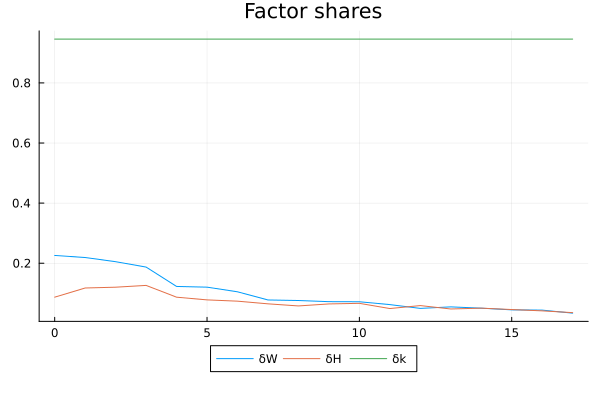

In [16]:
p = plot()
plot!(p,0:17,θk.δW,label = "δW")
plot!(p,0:17,θk.δH,label = "δH")
plot!(p,[0,17],[θk.δk,θk.δk],label = "δk")
title!("Factor shares")
plot!(legend=:outerbottom,legendcolumns=3)


### TFP

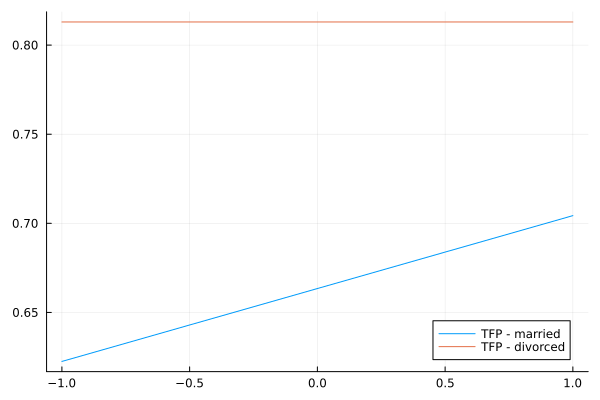

In [17]:
p = plot()
(;ω_grid) = F
(;γ_ψ) = θk

plot!(p,ω_grid,γ_ψ[2] .+ γ_ψ[3]*ω_grid,label = "TFP - married")
plot!(p,[-1,1],[γ_ψ[1],γ_ψ[1]],label="TFP - divorced")

## Fit of Production Moments

We fit three sets of moments when estimating production parameters: average test scores by age and marital status, standard deviations of test scores by age, and a pair of regression coefficients (described below).

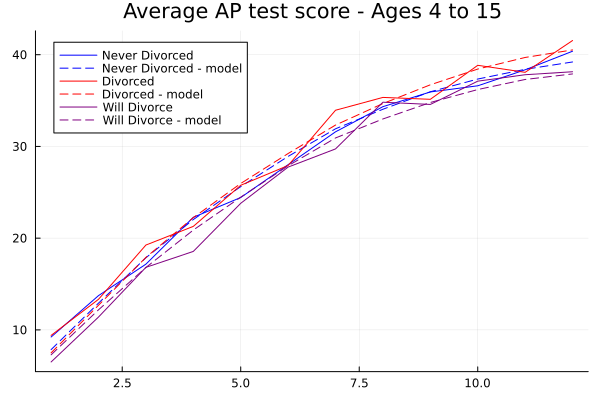

In [18]:
kmoms0 = kidmoms_data(K)
sim_data = (TD,TF,L_sim, Ω_sim, D)
kid_data = prep_child_data(sim_data,dat,cprobs);
S = zeros(length(kid_data.ΩK))
kmoms1 = kid_moments(S,θk,θ,F,kid_data)

p = plot()
K0 = reshape(kmoms0[1],12,3)
K1 = reshape(kmoms1[1],12,3)
clrs = ["blue","red","purple"]
grp = ["Never Divorced","Divorced","Will Divorce"]
for i in 1:3
    plot!(p,K0[:,i],linecolor=clrs[i],label = grp[i])
    plot!(p,K1[:,i],linecolor=clrs[i],linestyle=:dash, label = string(grp[i]," - model"))
end
title!(p,"Average AP test score - Ages 4 to 15")
p

The figure above shows very close fit of average test scores for children whose parents never divorce, will divorce, or are divorced already.

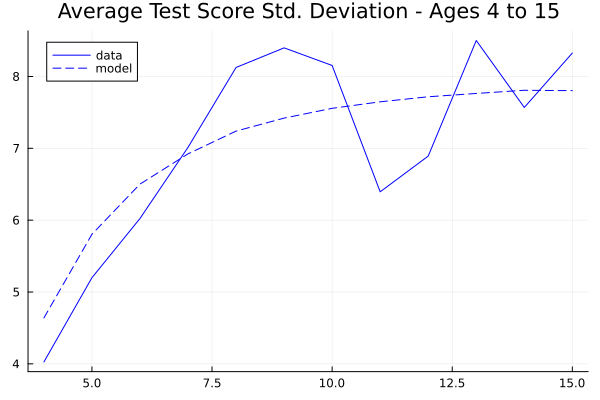

In [19]:
p = plot()
plot!(p,4:15,kmoms0[2],linecolor=:blue,label = "data")
plot!(p,4:15,kmoms1[2],linecolor=:blue,linestyle=:dash,label = "model")
title!(p,"Average Test Score Std. Deviation - Ages 4 to 15")

We also fit the standard deviation of test scores for children aged 4 to 15. This is to pin down two **new parameters** in the model. The first is a the standard deviation $\sigma_\eta$ of a mean zero normal shock to skill outcomes in every period.

The second is a parameter $\gamma_{AP}$ that embodies the *incremental difficulty* of the WJ test items in the Applied Problems Module. We now simulate total AP test score as:

$$ AP_{n} = \sum_{s=1}^{58}AP_{n,s} $$

where $AP_{n,s}=1$ only if item $s$ is answered correctly. This happens with probability :

$$ p(k,s) = \frac{\exp(\log(k) - \gamma_{AP}(-0.5 + s/58))}{1 + \exp(\log(k) - \gamma_{AP}(-0.5 + s/58))}.$$

Assuming a simple Binomial distribution leads to a natural U-shape in the variance of scores as ceiling effects kick in. The WJ is designed to avoid ceiling effects by making test items incrementally more difficult. The assumption above gives us this and allows us to capture the variance-age profile accurately.

I realized it was important to fit the overall distribution of skills because our measurement system is nonlinear and all the variance components matter for sccores.

Finally, we pin down factor shares by matching the coefficients from the following regression:

$AP_{n,t+5} = \beta_{0} + \beta_{1}\log(\tau_{m,t}) + \beta_{2}AP_{n,t} + \zeta_{n,t}$

from linking the 1997, 2002, and 2007 waves of the CDS. The table below reports the fit of coefficients $\hat{\beta}_{1}$ and $\hat{\beta}_{2}$.

In [20]:
DataFrame(coef = ["log mother's time","lagged test score"],data = kmoms0[3],model = kmoms1[3])

Row,coef,data,model
,String,Float64,Float64
1,log mother's time,0.493975,0.490278
2,lagged test score,0.4485,0.522044


## Decomposition of Divorce Impacts by Inputs

Next, as in the paper, we decompose skills into the accumulated affects of three sources: (1) Mother's time, (2) Father's time; and (3) TFP to see where differences in outcomes come from.



In [21]:
inputs,mstat = input_decomposition(θk,θ,F,kid_data)
d = [mean(inputs[:,mstat.==0],dims=2) mean(inputs[:,mstat.==1],dims=2)]
d_sum = sum(d,dims=1)
sd_skills = std(sum(inputs,dims=1))
d_gap = (d_sum[1] - d_sum[2]) / sd_skills
d ./= sd_skills


3×2 Matrix{Float64}:
 -1.90543  -1.48092
  1.67289   1.64358
  1.23825   1.10306

First note that estimates suggest that children of divorced couples have 20\% of a standard deviation less cognitive skill, which reflects differences in raw test scores in the data. We can use our decomposition to evaluate the contribution of three different channels:

In [22]:
DataFrame(Name = ["Total","TFP","Mother's Time","Father's Time"],Value = [d_gap;d[:,1] .- d[:,2]])

Row,Name,Value
,String,Float64
1,Total,-0.260015
2,TFP,-0.424513
3,Mother's Time,0.0293045
4,Father's Time,0.135193


Estimates suggest that half the gap is coming from TFP, which given our estimates is likely to have come from lower TFP prior to divorce.